# Approximating likelihood ratios with calibrated classifiers

Gilles Louppe, January 2016.


In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import theano
import theano.tensor as T

## Toy problem

Let us consider two 1D distributions $p_0$ and $p_1$ for which we want to approximate the ratio $r(x) = \frac{p_0(x)}{p_1(x)}$ of their densities.

- $p_1$ is defined as a mixture of two gaussians;
- $p_0$ is defined as a mixture of the same two gaussians + a bump.

In [5]:
from carl.distributions import Normal
from carl.distributions import Mixture

components = [
    Normal(mu=-2.0, sigma=0.75),   # c0
    Normal(mu=0.0, sigma=2.0),     # c1
    Normal(mu=1.0, sigma=0.5)      # c2 (bump)
]

bump_coefficient = 0.05
g = theano.shared(bump_coefficient) 
p0 = Mixture(components=components, weights=[0.5 - g / 2., 0.5 - g / 2., g])
p1 = Mixture(components=components[:2], weights=[0.5, 0.5])

Note: for $p_0$, weights are all tied together through the Theano shared variable `g`. This means that changes to the value stored in `g` also automatically change the weight values and the resulting mixture.

In [6]:
X_true = p0.rvs(5000, random_state=777)

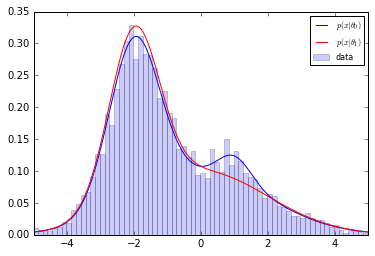

In [7]:
reals = np.linspace(-5, 5, num=1000)
plt.plot(reals, p0.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_0)$", color="b")
plt.plot(reals, p1.pdf(reals.reshape(-1, 1)), label=r"$p(x|\theta_1)$", color="r")
plt.hist(X_true[:, 0], bins=100, normed=True, label="data", alpha=0.2, color="b")
plt.xlim(-5, 5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

## Density ratio estimation

The density ratio $r(x)$ can be approximated using calibrated classifiers, either directly by learning to classify $x \sim p_0$ from $x \sim p_1$, or by decomposing the ratio of the two mixtures as pairs of simpler density ratios.

In [44]:
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import ElasticNetCV
from carl.ratios import ClassifierRatio
from carl.ratios import DecomposedRatio
from carl.learning import CalibratedClassifierCV

# clf = ElasticNetCV()
# clf = ExtraTreesRegressor(n_estimators=250, max_leaf_nodes=15)
clf = MLPRegressor(tol=1e-05, activation="logistic", 
                   hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                   learning_rate="constant", algorithm="l-bfgs", random_state=0, 
                   max_iter=75)
#clf = MLPRegressor(activation="tanh", hidden_layer_sizes=(10, 10), random_state=0)
n_samples = 100000

# No calibration
cc_none = ClassifierRatio(base_estimator=clf, random_state=1)
cc_none.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Direct approximation 
cv = StratifiedShuffleSplit(n_iter=1, test_size=0.5, random_state=0)
cc_direct = ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, bins=20, cv=cv), random_state=1)
cc_direct.fit(numerator=p0, denominator=p1, n_samples=n_samples)

# Calibration + Decomposition of the mixture
cc_decomposed = DecomposedRatio(ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, bins=20, cv=cv), random_state=1))
cc_decomposed.fit(numerator=p0, denominator=p1, n_samples=n_samples)

DecomposedRatio(base_ratio=ClassifierRatio(base_estimator=CalibratedClassifierCV(base_estimator=MLPRegressor(activation='logistic', algorithm='l-bfgs', alpha=0.0001,
       batch_size=200, beta_1=0.9, beta_2=0.999, early_stopping=False,
       epsilon=1e-08, hidden_layer_sizes=(10, 10),
       learning_rate='constant', learning_rate_init=1e-...iter=1, random_state=0, test_size=0.5,
            train_size=None),
            method='histogram'),
        random_state=1))

Note: `CalibratedClassifierRatio` takes three arguments for controlling its execution:
- `base_estimator` specifying the classifier to be used,
- `calibration` specifying the calibration algorithm (`"kde"`, `"histogram"`, or a user-defined distribution-like object),
- `cv` specifying how to allocate data for training and calibration.

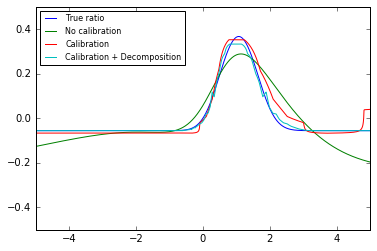

In [45]:
plt.plot(reals, -p0.nnlf(reals.reshape(-1, 1))  
                +p1.nnlf(reals.reshape(-1, 1)), label="True ratio")

plt.plot(reals, cc_none.predict(reals.reshape(-1, 1), log=True), label="No calibration")
plt.plot(reals, cc_direct.predict(reals.reshape(-1, 1), log=True), label="Calibration")
plt.plot(reals, cc_decomposed.predict(reals.reshape(-1, 1), log=True), label="Calibration + Decomposition")

plt.xlim(-5, 5)
plt.ylim(-0.5, 0.5)
plt.legend(loc="best", prop={'size': 8})
plt.show()

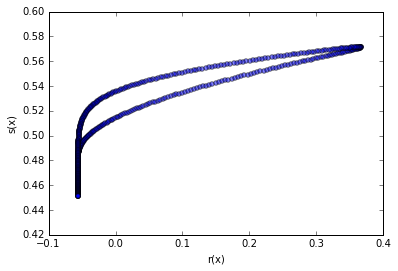

In [46]:
plt.scatter(-p0.nnlf(reals.reshape(-1, 1)) + p1.nnlf(reals.reshape(-1, 1)), 
            cc_none.classifier_.predict_proba(reals.reshape(-1, 1))[:, 0], alpha=0.5)
plt.xlabel("r(x)")
plt.ylabel("s(x)")

## Using density ratios for maximum likelihood fit

In the likelihood-free setting, density ratios can be used to find the maximum likelihood estimator $\theta^* = \arg \max_{\theta} p(D | \theta)$ by noticing that $\theta^*$ also maximizes $\prod_{x \in D} \frac{p(x|\theta)}{p(x|\theta_1)}$ for some fixed value of $\theta_1$.

As an example, this can be used to find the bump coefficient in $p_1$, as illustrated below:

In [ ]:
from sklearn.utils import check_random_state
from scipy.optimize import minimize

n_trials = 100  
mles = []

for i in range(n_trials):      
    # Reset
    rng = check_random_state(i)
    
    g.set_value(bump_coefficient)
    X_true = p0.rvs(5000, random_state=rng)
    
    # Fit ratio
    clf = MLPRegressor(tol=1e-05, activation="logistic", 
                       hidden_layer_sizes=(10, 10), learning_rate_init=1e-07, 
                       learning_rate="constant", algorithm="l-bfgs", random_state=rng, 
                       max_iter=75)
    cc = DecomposedRatio(ClassifierRatio(base_estimator=CalibratedClassifierCV(clf, cv=cv, bins=20), 
                                         random_state=rng))
    cc.fit(numerator=p0, denominator=p1, n_samples=100000)

    # Inference
    def objective(theta):       
        g.set_value(theta[0])  # this indirectly updates weights in p1, 
                               # along with the density ratios computed by cc 
                               # (without having to retrain the classifiers since 
                               # g only affects the weights!)

        return -np.mean(cc.predict(X_true, log=True))

    results = minimize(objective, x0=[0.1], 
                       constraints=[{'type':'ineq', 'fun': lambda x: x[0]},
                                    {'type':'ineq', 'fun': lambda x: 1. - x[0]},])

    mles.append(results.x[0])

In [48]:
mles = np.array(mles)
np.mean(mles[np.isfinite(mles)])

0.050077534130274895

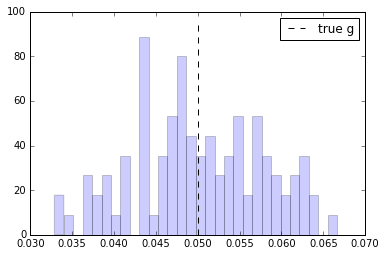

In [49]:
h = plt.hist(mles[np.isfinite(mles)], bins=30, normed=1, alpha=0.2)
plt.vlines(bump_coefficient, 0, h[0].max()+5, linestyles="dashed", label="true g")
plt.legend()
plt.show()